Cluster 1: 6 pts → rect 428x135
Cluster 5: 8 pts → rect 453x147
Cluster 6: 10 pts → rect 456x148
Cluster 7: 8 pts → rect 454x147
Cluster 11: 6 pts → rect 423x145
Cluster 15: 5 pts → rect 453x145
Cluster 19: 5 pts → rect 453x146
Cluster 21: 9 pts → rect 459x146
Cluster 35: 5 pts → rect 546x172
COCA-COLA-LOGO.jpg → 4 logos detectados (guardado en ./resultados/deteccion_COCA-COLA-LOGO.jpg)


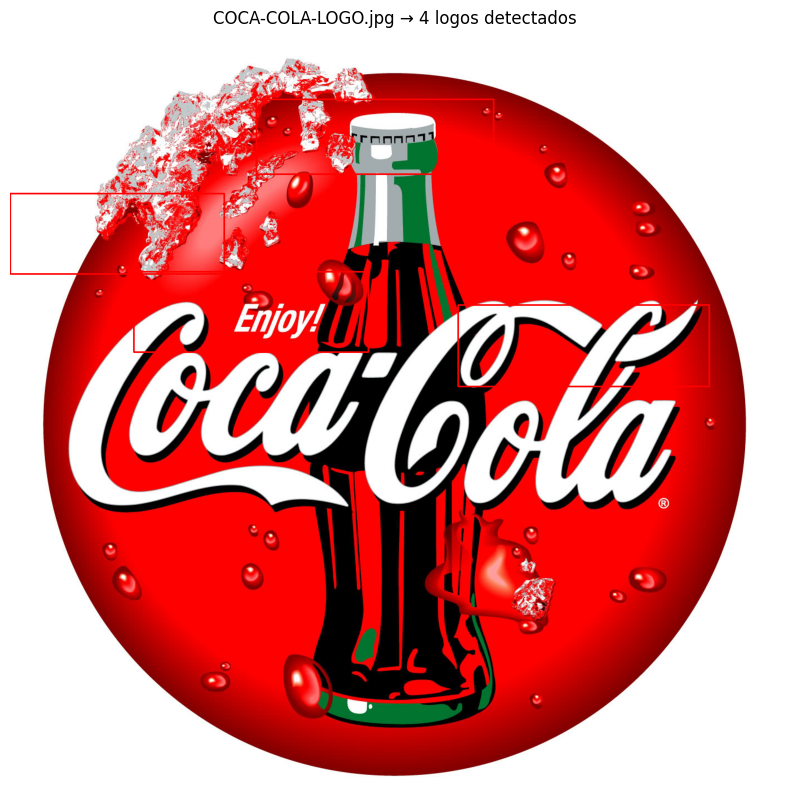

Cluster 0: 7 pts → rect 464x148
Cluster 4: 6 pts → rect 425x137
Cluster 6: 6 pts → rect 455x147
Cluster 7: 11 pts → rect 459x156
coca_logo_1.png → 1 logos detectados (guardado en ./resultados/deteccion_coca_logo_1.png)


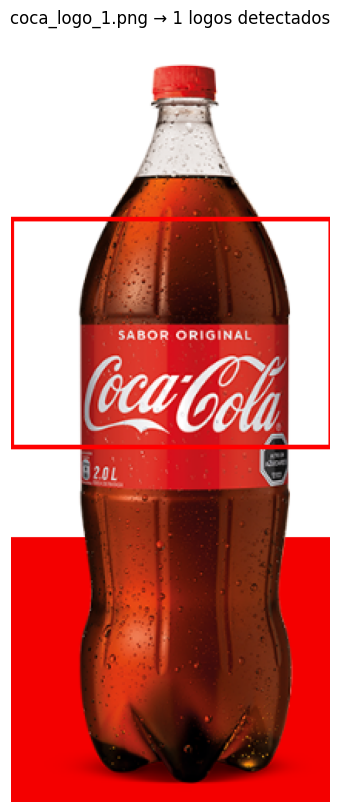

Cluster 3: 5 pts → rect 531x179
coca_logo_2.png → 1 logos detectados (guardado en ./resultados/deteccion_coca_logo_2.png)


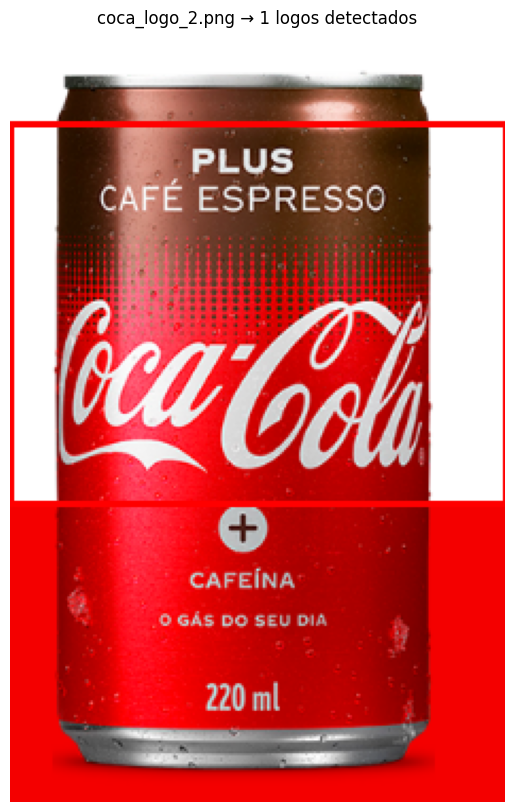

Cluster 0: 16 pts → rect 469x154
Cluster 1: 8 pts → rect 495x158
Cluster 2: 5 pts → rect 379x121
Cluster 4: 6 pts → rect 453x147
Cluster 5: 5 pts → rect 456x147
Cluster 6: 10 pts → rect 455x162
Cluster 7: 7 pts → rect 454x145
Cluster 8: 5 pts → rect 464x156
Cluster 9: 5 pts → rect 453x145
Cluster 11: 5 pts → rect 379x120
Cluster 12: 7 pts → rect 455x151
Cluster 18: 6 pts → rect 456x148
coca_retro_1.png → 0 logos detectados (guardado en ./resultados/deteccion_coca_retro_1.png)


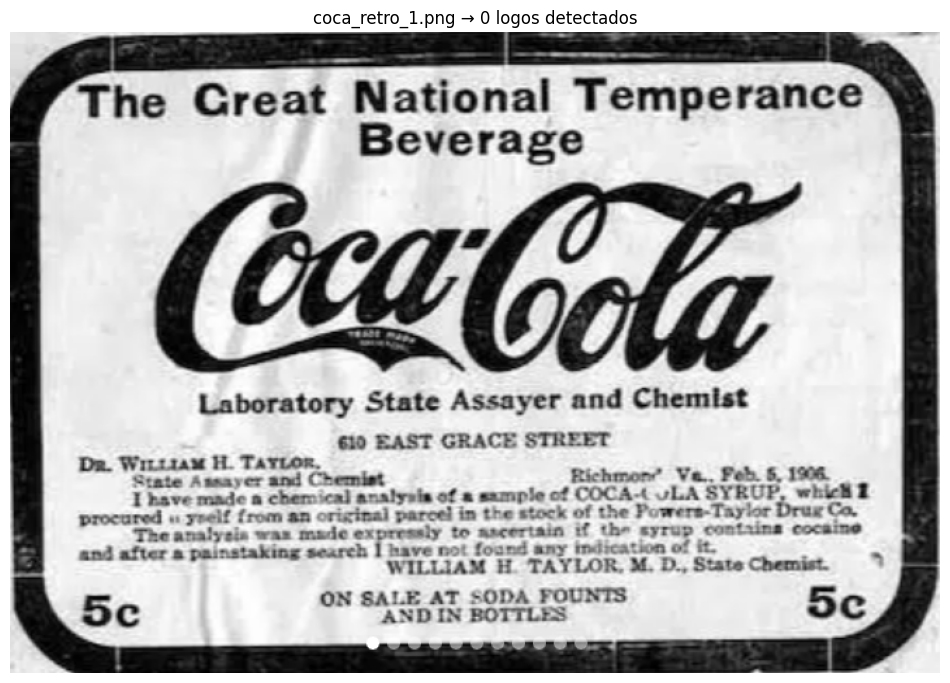

Cluster 3: 5 pts → rect 454x145
Cluster 6: 5 pts → rect 457x146
coca_retro_2.png → 1 logos detectados (guardado en ./resultados/deteccion_coca_retro_2.png)


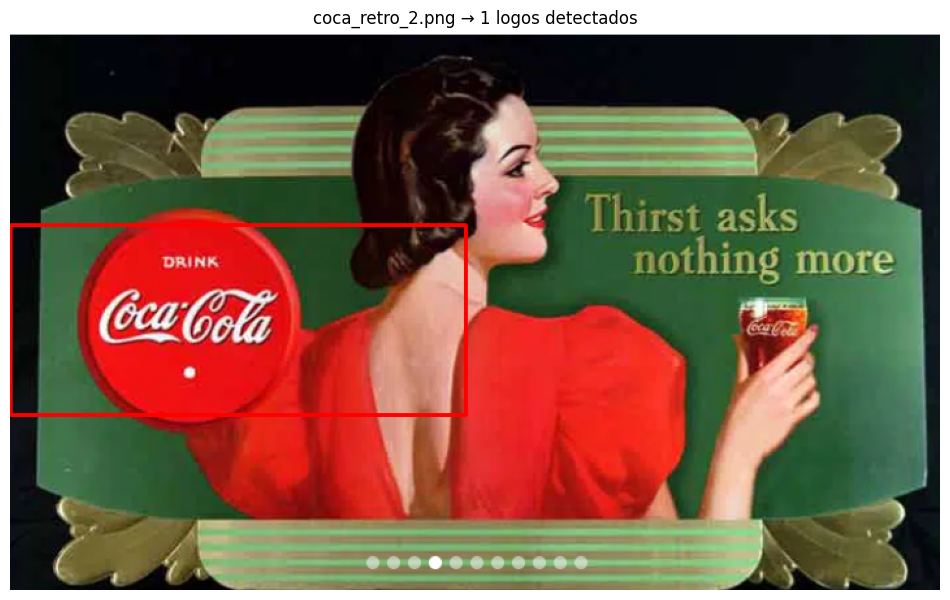

Cluster 1: 7 pts → rect 470x151
Cluster 3: 5 pts → rect 455x153
logo_1.png → 1 logos detectados (guardado en ./resultados/deteccion_logo_1.png)


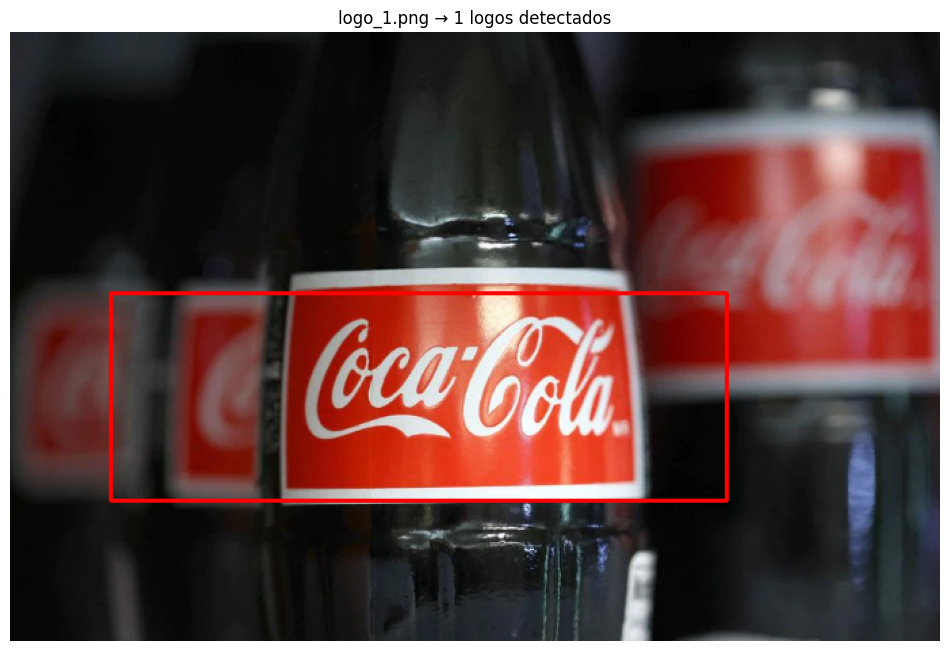

In [3]:
# PUNTO 3 – Detección avanzada de logos Coca-Cola (ORB + multi-scale + DBSCAN + filtros)
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive
import os
from sklearn.cluster import DBSCAN

# --------------------------
# 1) Montar Google Drive
# --------------------------
# drive.mount('/content/gdrive', force_remount=True)

# --------------------------
# 2) Rutas y parámetros
# --------------------------
base_dir = '.'
images_dir = os.path.join(base_dir, 'images')
template_path = os.path.join(base_dir, 'template/pattern_cropped.png')  # template de Coca-Cola
results_dir = os.path.join(base_dir, 'resultados')
os.makedirs(results_dir, exist_ok=True)

# Parámetros ajustables
SCALE_FACTORS = [0.6, 0.8, 1.0, 1.2, 1.4]
EPS_CLUSTER = 20              
MIN_SAMPLES_CLUSTER = 1
MIN_INLIERS_PER_CLUSTER = 5  
MAX_BOX_FACTOR = 2.2
NMS_OVERLAP = 0.3
RED_RATIO_MIN = 0.40         
ORB_NFEATURES = 600
MATCH_DIST_THRESH = 58     
V_MIN_HSV_THRESH = 120        
ASPECT_RATIO_MAX_FACTOR = 1.6 
ASPECT_RATIO_MIN_FACTOR = 0.6

# --------------------------
# 3) Cargar template
# --------------------------
template_orig = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
if template_orig is None:
    raise FileNotFoundError(f"No se pudo cargar el template: {template_path}")

tpl_h0, tpl_w0 = template_orig.shape[:2]

# --------------------------
# 4) Inicializar ORB y BFMatcher
# --------------------------
orb = cv.ORB_create(nfeatures=ORB_NFEATURES)
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# --------------------------
# 5) Listar imágenes (excluyendo coca_multi)
# --------------------------
image_files = [
    f for f in os.listdir(images_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg')) and 'coca_multi' not in f.lower()
]
if len(image_files) == 0:
    raise ValueError("No se encontraron imágenes válidas en la carpeta (excluyendo coca_multi).")

# --------------------------
# 6) Procesar cada imagen
# --------------------------
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    img_color = cv.imread(image_path)
    if img_color is None:
        print(f"No se pudo leer {image_file}, saltando...")
        continue
    img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)

    kp2, des2 = orb.detectAndCompute(img_gray, None)
    if des2 is None or len(kp2) == 0:
        print(f"{image_file} → no hay descriptores en la imagen")
        continue

    all_matches_pts = []

    for scale in SCALE_FACTORS:
        w_scaled = max(1, int(tpl_w0 * scale))
        h_scaled = max(1, int(tpl_h0 * scale))
        template = cv.resize(template_orig, (w_scaled, h_scaled))

        kp1, des1 = orb.detectAndCompute(template, None)
        if des1 is None or len(kp1) == 0:
            continue

        matches = bf.match(des1, des2)
        good_matches = [m for m in matches if m.distance < MATCH_DIST_THRESH]

        for m in good_matches:
            x, y = kp2[m.trainIdx].pt
            all_matches_pts.append((x, y, w_scaled, h_scaled))

    if len(all_matches_pts) == 0:
        print(f"{image_file} → 0 logos detectados (no hubo matches)")
        cv.imwrite(os.path.join(results_dir, f"deteccion_{image_file}"), img_color)
        continue

    points = np.array([[x, y] for x, y, w, h in all_matches_pts])
    db = DBSCAN(eps=EPS_CLUSTER, min_samples=MIN_SAMPLES_CLUSTER).fit(points)
    labels = db.labels_

    unique_labels = [lab for lab in set(labels) if lab != -1]
    rectangles = []

    for label in unique_labels:
        inds = np.where(labels == label)[0]
        cluster_pts = points[inds]
        cluster_ws = np.array([all_matches_pts[i][2] for i in inds])
        cluster_hs = np.array([all_matches_pts[i][3] for i in inds])

        cx, cy = np.mean(cluster_pts, axis=0)
        dist = np.linalg.norm(cluster_pts - np.array([cx, cy]), axis=1)
        thresh = np.percentile(dist, 80)
        inlier_mask = dist <= thresh
        cluster_pts_in = cluster_pts[inlier_mask]
        if len(cluster_pts_in) < MIN_INLIERS_PER_CLUSTER:
            continue

        w_med = int(np.median(cluster_ws[inlier_mask]))
        h_med = int(np.median(cluster_hs[inlier_mask]))

        x_min = int(np.min(cluster_pts_in[:, 0]) - w_med / 2)
        y_min = int(np.min(cluster_pts_in[:, 1]) - h_med / 2)
        x_max = int(np.max(cluster_pts_in[:, 0]) + w_med / 2)
        y_max = int(np.max(cluster_pts_in[:, 1]) + h_med / 2)

        max_w = int(tpl_w0 * MAX_BOX_FACTOR)
        max_h = int(tpl_h0 * MAX_BOX_FACTOR)
        w_box = min(x_max - x_min, max_w)
        h_box = min(y_max - y_min, max_h)

        if w_box <= 0 or h_box <= 0:
            continue

        tpl_ratio = tpl_w0 / float(tpl_h0)
        box_ratio = w_box / float(h_box)
        if box_ratio > tpl_ratio * 2.0 or box_ratio < tpl_ratio * 0.5:
            continue

        rectangles.append([x_min, y_min, int(w_box), int(h_box)])
        print(f"Cluster {label}: {len(cluster_pts_in)} pts → rect {int(w_box)}x{int(h_box)}")

    detections_count = 0
    if len(rectangles) == 0:
        print(f"{image_file} → 0 logos detectados (no quedaron rectángulos tras filtrado)")
        cv.imwrite(os.path.join(results_dir, f"deteccion_{image_file}"), img_color)
        plt.figure(figsize=(10, 8))
        plt.imshow(cv.cvtColor(img_color, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"{image_file} → 0 logos detectados")
        plt.show()
        continue

    scores = [1.0] * len(rectangles)
    pick = cv.dnn.NMSBoxes(rectangles, scores, score_threshold=0.0, nms_threshold=NMS_OVERLAP)

    pick_idxs = []
    if pick is not None:
        for p in pick:
            if isinstance(p, (list, tuple, np.ndarray)):
                if len(p) > 0:
                    pick_idxs.append(int(p[0]))
            else:
                pick_idxs.append(int(p))

    for idx in pick_idxs:
        x, y, w_box, h_box = rectangles[idx]
        x1 = max(0, x)
        y1 = max(0, y)
        x2 = min(img_color.shape[1], x + w_box)
        y2 = min(img_color.shape[0], y + h_box)
        if x2 <= x1 or y2 <= y1:
            continue

        roi = img_color[y1:y2, x1:x2]
        if roi.size == 0:
            continue

        roi_hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
        mask1 = cv.inRange(roi_hsv, (0, 100, 80), (10, 255, 255))
        mask2 = cv.inRange(roi_hsv, (170, 100, 80), (180, 255, 255))
        mask_red = cv.bitwise_or(mask1, mask2)
        red_ratio = cv.countNonZero(mask_red) / float(roi.shape[0] * roi.shape[1])

        if red_ratio < RED_RATIO_MIN:
            continue

        cv.rectangle(img_color, (x1, y1), (x2, y2), (0, 0, 255), 2)
        detections_count += 1

    result_path = os.path.join(results_dir, f"deteccion_{image_file}")
    cv.imwrite(result_path, img_color)
    print(f"{image_file} → {detections_count} logos detectados (guardado en {result_path})")

    plt.figure(figsize=(12, 10))
    plt.imshow(cv.cvtColor(img_color, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{image_file} → {detections_count} logos detectados")
    plt.show()